# Class2 协整性套利

## 什么协整性？
两变量间具有长期稳定关系。这与相关性不同。

协整关系存在的条件是：只有当两个变量的时间序列{x}和{y}是同阶单整序列即I(d)时，才可能存在协整关系(这一点对多变量协整并不适用)。

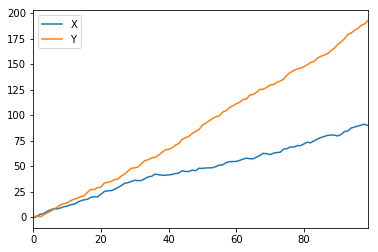

In [1]:
import numpy as np
import pandas as pd
import statsmodels.tsa.stattools as sts
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint

np.random.seed(100)

X = np.random.normal(1,1,100)
Y = np.random.normal(2,1,100)

X_cum = pd.Series(np.cumsum(X), name='X')
Y_cum = pd.Series(np.cumsum(Y), name='Y')

pd.concat([X_cum, Y_cum], axis=1).plot()
plt.show()

In [2]:
_, pvalue, _ = coint(X_cum, Y_cum)
corr = np.corrcoef(X_cum, Y_cum)[0,1]
print ('cointegration pvalue = ',pvalue)
print ('correlation coefficient = ',corr)

('cointegration pvalue = ', 0.14205235734673188)
('correlation coefficient = ', 0.99049943000329876)


In [3]:
X = pd.Series(2*np.random.normal(0,1,1000)) + 50
X_wave = X.copy()
print X_wave.tail()

995    51.432222
996    49.495931
997    53.336359
998    48.333037
999    52.330364
dtype: float64


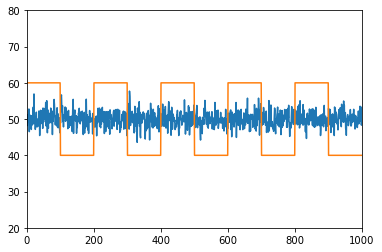

In [4]:
X_wave[:100] = 60
X_wave[100:200] = 40
X_wave[200:300] = 60
X_wave[300:400] = 40
X_wave[400:500] = 60
X_wave[500:600] = 40
X_wave[600:700] = 60
X_wave[700:800] = 40
X_wave[800:900] = 60
X_wave[900:1000] = 40

X.plot()
X_wave.plot()
plt.ylim([20,80])
plt.show()

In [5]:
_, pvalue, _ = coint(X, X_wave)
corr = np.corrcoef(X, X_wave)[0,1]
print ('cointegration pvalue = ',pvalue)
print ('correlation coefficient = ',corr)

('cointegration pvalue = ', 4.4587487632006054e-09)
('correlation coefficient = ', 0.0087557620813576015)


以上两个虚构的例子只是为了说明协整和相关性并不是一回事，大家要走出这个误区，不能简单的以相关性的高低来判断协整关系的强弱
下面我们以真实市场的股票价格来进行配对交易的策略设计

## Step_1 Get Data

In [6]:
#coding=utf-8

## Step 1 Get Classified Code

# import tushare as ts
#
# data = ts.get_industry_classified()
# print(data)
# data.to_excel('classified.xlsx')

import pandas as pd

data = pd.read_excel('D:/PycharmProjects/Quant_Alpha/Strategies_test/Pair_Trading/classified.xlsx')
cond = data.c_name==u'家电行业'
code = list(data[cond].code)

codes = []
for c in code:
    stocks = '%06.f'%c
    codes.append(stocks)

def coder(code):
    if code.startswith('6'):
        return code + '.XSHG'
    elif code.startswith('0') or code.startswith('3'):
        return code + '.XSHE'
    else:
        return code

stock_list = map(coder, codes)
household = tuple(stock_list)

# Step 2 Get Data

from fxdayu_data import DataAPI
from datetime import datetime

DataAPI.set_file('D:/PycharmProjects/Quant_Alpha/Data_Manager/config.py')
PN_Candle = DataAPI.candle(household, 'D', start=datetime(2016,1,1))

print(PN_Candle)

[Errno 2] No such file or directory: 'config.py'
<class 'pandas.core.panel.Panel'>
Dimensions: 36 (items) x 232 (major_axis) x 5 (minor_axis)
Items axis: 000016.XSHE to 603519.XSHG
Major_axis axis: 2016-01-04 15:00:00 to 2016-12-14 15:00:00
Minor_axis axis: close to volume


## Step_2 Test Co-integration

[('002290.XSHE', '002508.XSHE', 0.030043452873596586)]
[[ 1.          0.98590026  0.98590026 ...,  0.98590026  0.98590026
   0.98590026]
 [ 1.          1.          0.98590026 ...,  0.98590026  0.98590026
   0.98590026]
 [ 1.          1.          1.         ...,  0.98590026  0.98590026
   0.98590026]
 ..., 
 [ 1.          1.          1.         ...,  1.          0.98590026
   0.98590026]
 [ 1.          1.          1.         ...,  1.          1.          0.98590026]
 [ 1.          1.          1.         ...,  1.          1.          1.        ]]


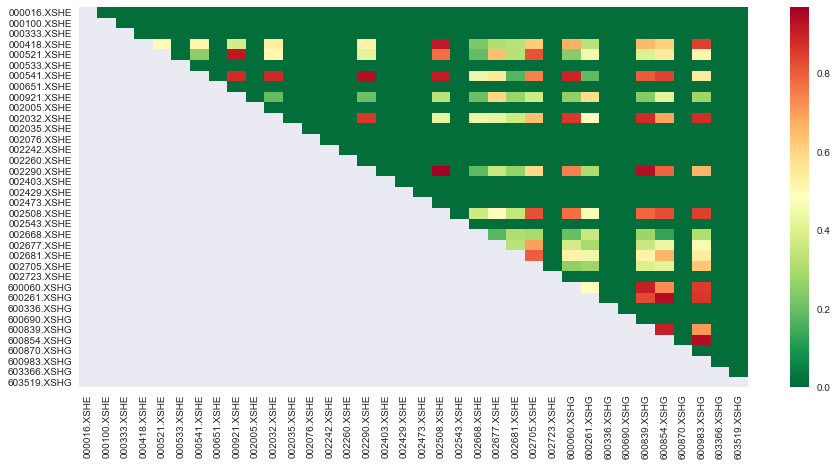

In [15]:
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def find_cointegrated_pairs(dataframe):
    # 得到DataFrame长度
    n = dataframe.shape[1]
    # 初始化p值矩阵
    pvalue_matrix = np.ones((n, n))
    # 抽取列的名称
    keys = dataframe.keys()
    # 初始化强协整组
    pairs = []
    # 对于每一个i
    for i in range(n):
        # 对于大于i的j
        for j in range(i+1, n):
            # 获取相应的两只股票的价格Series
            stock1 = dataframe[keys[i]]
            stock2 = dataframe[keys[j]]
            # 分析它们的协整关系
            result = sm.tsa.stattools.coint(stock1, stock2)
            # 取出并记录p值
            pvalue = result[1]
            pvalue_matrix[i, j] = pvalue
            # 如果p值小于0.05
            if pvalue < 0.05:
                # 记录股票对和相应的p值
                pairs.append((keys[i], keys[j], pvalue))
    # 返回结果
    return pvalue_matrix, pairs

df = PN_Candle.minor_xs('close')
pv, pairs = find_cointegrated_pairs(df)
print(pairs)
print pv
fig = plt.figure(figsize=(15, 7))
sns.heatmap(1-pv, xticklabels=df.columns, yticklabels=df.columns, cmap='RdYlGn_r', mask=(pv==1))
plt.show()

## Step_3 Plot Two Stocks

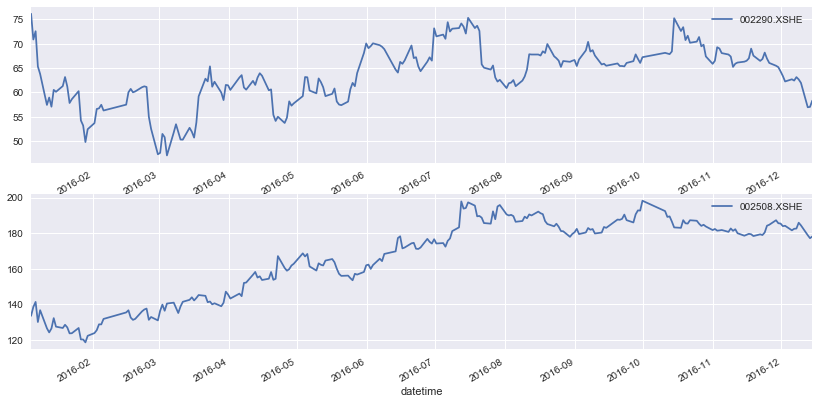

In [16]:
stock_sample1 = df['002290.XSHE']
stock_sample2 = df['002508.XSHE']
plt.subplot(2, 1, 1)
stock_sample1.plot(figsize=(14,7), label='002290.XSHE')
plt.legend()
plt.subplot(2, 1, 2)
stock_sample2.plot(figsize=(14,7), label='002508.XSHE')
plt.legend()
plt.show()

## Step_4 Regression Summary

In [17]:
x = stock_sample1
y = stock_sample2
X = sm.add_constant(x)
result = (sm.OLS(y,X)).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            002508.XSHE   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     177.0
Date:                Sat, 24 Jun 2017   Prob (F-statistic):           2.48e-30
Time:                        09:49:09   Log-Likelihood:                -979.45
No. Observations:                 232   AIC:                             1963.
Df Residuals:                     230   BIC:                             1970.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          11.8489     11.645      1.017      

-squred为0.435，说明我们拟合的参数解释了0.435%的样本数据，说明拟合结果一般，AIC与BIC检验较小说明回归效果好，再来看看系数是否统计显著，const的系数的绝对值除标准误差为0.31，说明统计显著性一般，或许需要找其他行业来测试看看，这里只做一个例子。
接下来我们看看线性组合的价差是否是在均值周围波动。

## Plot The Confidence Band

-0.00110710094827
16.4909430332


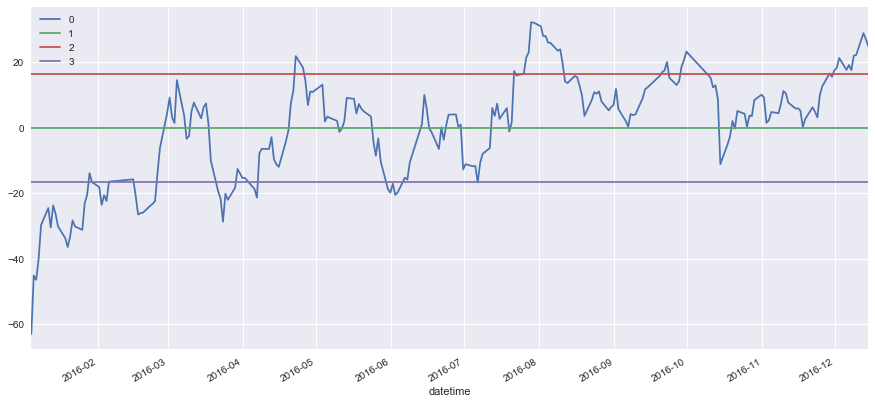

In [28]:
diff=y-2.4261*x-11.8489
mean=np.mean(diff)
std=np.std(diff)
print (mean)
print(std)
up=mean+std
down=mean-std
time=diff.index
mean_line=pd.Series(mean,index=time)
up_line=pd.Series(up,index=time)
down_line=pd.Series(down,index=time)
chart = pd.concat([diff,mean_line,up_line,down_line],axis=1)
chart.plot(figsize=(15,7))
plt.show()

    至此，我们完成了配对交易的准备步骤，找到了协整股票对之间的线性关系以及股价差满足的模型，我们以'002508.XSHG'的股价减去拟合的系数2.4261倍'002290.XSHG'的股价，线性组合价差服从均值为11.84标准误差为16.49的正态分布。根据这样的线性关系，我们构建这么一个简单的配对交易策略：组合价差超过均值+1倍标准误差即卖出002508，买入002290；低于均值1倍标准误差即买入002508，卖出002290.

In [ ]:
import talib as ta
